# Enviroment Setup

In [1]:
%pip install ultralytics
!pip install roboflow
%pip install deep_sort_realtime
%pip install supervision
!pip install easyocr


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 115.0 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 6.3 MB/s eta 0:00:00
   ━━━━

# Dependance

In [2]:
import cv2, numpy as np
from ultralytics import YOLO
from collections import defaultdict, deque
from sklearn.cluster import KMeans
from roboflow import Roboflow
import cv2
import os
import math
import random
import pandas as pd
import supervision as sv
from tqdm import tqdm
from sklearn.metrics import pairwise_distances_argmin_min

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# rf = Roboflow(api_key="BdT2qrw9k8MlB6ysrcW7")
# project = rf.workspace("moemn-adel").project("football-players-detection-3zvbc-4bjwj")
# version = project.version(3)
# dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-players-detection-3 in yolov11:: 100%|██████████| 1804/1804 [00:00<00:00, 2394.37it/s]


In [3]:
# !pip install roboflow

# from roboflow import Roboflow
rf = Roboflow(api_key="BdT2qrw9k8MlB6ysrcW7")
project = rf.workspace("moemn-adel").project("football-player-detect-zjoxy-ywtkn")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to football-player-detect-1 in yolov11:: 100%|██████████| 20192/20192 [00:03<00:00, 6585.56it/s] 


In [ ]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)

# تدريب
model.train(
    data="/content/football-player-detect-1/data.yaml",
    epochs=500,
    imgsz=640,
)



image 1/1 /content/football-player-detect-1/test/images/173_pp_jpg.rf.281793e8f497ddf7dde5f45e79e586c1.jpg: 640x640 2 goalkeepers, 20 players, 1 referee, 8.9ms
Speed: 4.9ms preprocess, 8.9ms inference, 258.5ms postprocess per image at shape (1, 3, 640, 640)


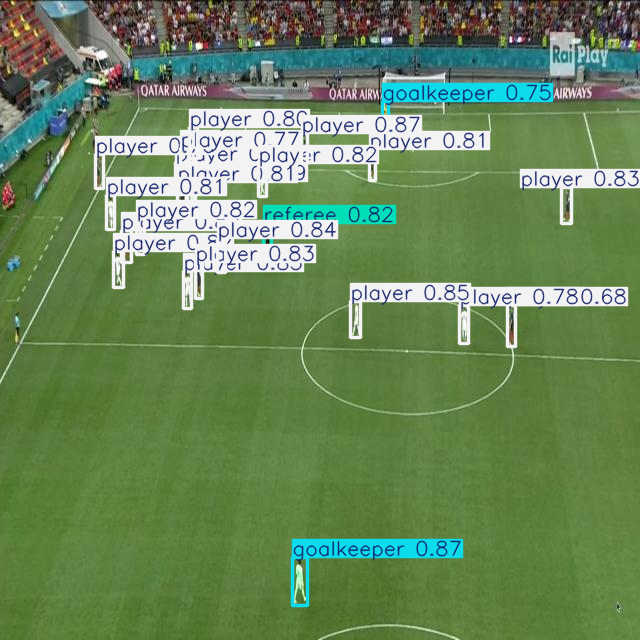

In [4]:
import matplotlib.pyplot as plt
# Load a model
model = YOLO("/content/best 1k.pt")  # load a custom model

# Predict with the model
results = model("/content/football-player-detect-1/test/images/173_pp_jpg.rf.281793e8f497ddf7dde5f45e79e586c1.jpg")  # predict on an image
results[0].show()


# Utilities

**Explanation:**

* Helper functions to calculate the center and width of bounding boxes.


* `is_inside_pitch` filters detections outside the playable area.

In [27]:
# def get_center_of_bbox(bbox):
#     x1, y1, x2, y2 = bbox
#     return ((x1 + x2) / 2.0, (y1 + y2) / 2.0)

# def get_bbox_width(bbox):
#     x1, y1, x2, y2 = map(int, bbox)
#     return max(1, x2 - x1)

def is_inside_pitch(bbox, frame_shape, margin=40):    #margin=10 , 0
    h, w = frame_shape[:2]
    x1, y1, x2, y2 = map(int, bbox)
    if x1 < margin or y1 < margin or x2 > (w - margin) or y2 > (h - margin):
        return False
    return True

# Annotation Drawer


**Explanation:**

* Draw ellipses for players, triangles for the ball, and optionally text labels for each team.

* `draw_annotations` loops through frames and draws all detected objects.

In [39]:
class AnnotationDrawer:
    def draw_ellipse(self, frame, bbox, color, label=None):
        y2 = int(bbox[3])
        x_center, _ = self.get_center_of_bbox(bbox)
        width = self.get_bbox_width(bbox)

        cv2.ellipse(
            img=frame,
            center=(int(x_center), int(y2)),
            axes=(int(width), int(0.35 * width)),
            angle=0,
            startAngle=-45,
            endAngle=235,
            color=color,
            thickness=2,
            lineType=cv2.LINE_4
        )

        if label is not None:
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 0.7
            thickness = 2
            # size text
            (text_width, text_height), baseline = cv2.getTextSize(label, font, font_scale, thickness)
            # ceneter text
            text_x = int(x_center - text_width / 2)
            text_y = int(y2 + text_height + 5)
            cv2.putText(frame, label, (text_x, text_y), font, font_scale, (255, 255, 255), thickness)

        return frame


    def draw_triangle(self, frame, bbox, color):
        x1, y1, x2, y2 = map(int, bbox)
        cx = (x1 + x2) // 2
        triangle_points = np.array(
            [[cx, y1], [cx - 10, y1 - 20], [cx + 10, y1 - 20]], dtype=np.int32
        )
        cv2.drawContours(frame, [triangle_points], 0, color, cv2.FILLED)
        cv2.drawContours(frame, [triangle_points], 0, (0, 0, 0), 2)
        return frame

    def draw_annotations(self, video_frames, tracks, team_ball_control=None):
        out = []
        for f_idx, frame in enumerate(video_frames):
            canvas = frame.copy()
            players = tracks.get("players", [])[f_idx]
            referees = tracks.get("referees", [])[f_idx]
            balls = tracks.get("ball", [])[f_idx]

            # Player
            for pid, p in players.items():
                if not is_inside_pitch(p["bbox"], frame.shape):
                    continue
                team_id = p.get("team_id")
                if team_id not in [1, 2]:
                    continue

                color = p.get("team_color", (0, 255, 0))
                label = "A" if team_id == 1 else "B"

                # if team_id == 1:
                #     color = (0, 0, 255)   # أحمر
                #     label = "A"
                # else:
                #     color = (255, 0, 0)   # أزرق
                #     label = "B"

                canvas = self.draw_ellipse(canvas, p["bbox"], color, label)

            # Referes
            for rid, r in referees.items():
                canvas = self.draw_ellipse(canvas, r["bbox"], (0, 255, 255), "R")

            # ball
            for bid, b in balls.items():
                canvas = self.draw_triangle(canvas, b["bbox"], (0, 255, 0))

            out.append(canvas)
        return out

    @staticmethod
    def get_center_of_bbox(bbox):
        x1, y1, x2, y2 = bbox
        return (int((x1 + x2) / 2), int((y1 + y2) / 2))

    @staticmethod
    def get_bbox_width(bbox):
        x1, _, x2, _ = map(int, bbox)
        return max(1, x2 - x1)


# Color / Re-ID helpers

**Explanation:**

* Crop the chest region of players for color analysis.

* Compute hue vectors and HSV histograms for team identification.

* `_hist_distance` calculates similarity between histograms.

In [48]:
def _crop_chest(frame, bbox, chest_frac=(0.25,0.6)):
    x1, y1, x2, y2 = map(int, bbox)
    w = max(1, x2 - x1); h = max(1, y2 - y1)
    ys = y1 + int(h * chest_frac[0]); ye = y1 + int(h * chest_frac[1])
    xs = x1 + int(0.15 * w); xe = x2 - int(0.15 * w)
    ys = max(0, ys); ye = min(frame.shape[0], ye)
    xs = max(0, xs); xe = min(frame.shape[1], xe)
    if ye <= ys or xe <= xs:
        return None
    return frame[ys:ye, xs:xe]

def _hue_vector_for_crop(crop):
    if crop is None or crop.size == 0:
        return None
    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
    hue = hsv[:, :, 0].astype(np.float32)
    ang = hue / 179.0 * 2.0 * math.pi
    cos_mean = float(np.cos(ang).mean())
    sin_mean = float(np.sin(ang).mean())
    return np.array([cos_mean, sin_mean], dtype=np.float32)

def _hsv_hist_signature(crop, h_bins=32, s_bins=8):
    if crop is None or crop.size == 0:
        return None
    hsv = cv2.cvtColor(crop, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1], None, [h_bins, s_bins], [0,180, 0,256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def _hist_distance(a,b):
    if a is None or b is None: return 1.0
    a = a / (np.linalg.norm(a) + 1e-9)
    b = b / (np.linalg.norm(b) + 1e-9)
    return 1.0 - float(np.dot(a, b))


# Assign Team Colors

**Explanation:**

* Compute color features for each player track.

* Cluster players into two teams based on color similarity.

* Assign consistent team colors.

In [49]:
# main assign with re-id/gallery matching (stable team color)
def assign_team_colors_with_reid(frames, tracks,
                                 min_samples_per_track=6,
                                 chest_frac=(0.25,0.6),
                                 size_threshold_ratio=0.001,
                                 n_clusters=2):
    h, w = frames[0].shape[:2]
    frame_area = h*w
    per_track_vecs = defaultdict(list)
    per_track_hists = defaultdict(list)

    # collect per-track signatures from all frames
    for fi, frame in enumerate(frames):
        pdict = tracks["players"][fi]
        for tid, p in pdict.items():
            bbox = p.get("bbox")
            if bbox is None: continue
            x1,y1,x2,y2 = map(int, bbox)
            area = max(1,(x2-x1)*(y2-y1))
            if area < size_threshold_ratio * frame_area:
                continue
            crop = _crop_chest(frame, bbox, chest_frac)
            vec = _hue_vector_for_crop(crop)
            hist = _hsv_hist_signature(crop)
            if vec is None or hist is None: continue
            per_track_vecs[tid].append(vec)
            per_track_hists[tid].append(hist)

    candidate_tids = []
    candidate_vecs = []
    candidate_hists = []
    for tid, vecs in per_track_vecs.items():
        if len(vecs) < min_samples_per_track: continue
        mean_vec = np.stack(vecs,0).mean(axis=0)
        norm = np.linalg.norm(mean_vec)
        if norm > 0: mean_vec = mean_vec / norm
        mean_hist = np.stack(per_track_hists[tid],0).mean(axis=0)
        candidate_tids.append(tid)
        candidate_vecs.append(mean_vec)
        candidate_hists.append(mean_hist)

    if len(candidate_vecs) < n_clusters:
        for fi in range(len(frames)):
            for tid, p in tracks["players"][fi].items():
                p["team_id"] = None
                p["team_color"] = (0,255,0)
        print("[team-color] not enough confirmed tracks for clustering")
        return tracks

    X = np.stack(candidate_vecs,0)
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10).fit(X)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    cluster_hist = {i: [] for i in range(n_clusters)}
    for tid, lbl, hist in zip(candidate_tids, labels, candidate_hists):
        cluster_hist[lbl].append(hist)
    cluster_hist_mean = {}
    for i in cluster_hist:
        if cluster_hist[i]:
            cluster_hist_mean[i] = np.stack(cluster_hist[i],0).mean(axis=0)
        else:
            cluster_hist_mean[i] = None

    team_color_map = {}
    for i, c in enumerate(centers):
        cx, cy = float(c[0]), float(c[1])
        ang = math.atan2(cy, cx)
        if ang < 0: ang += 2*math.pi
        hue = ang / (2*math.pi) * 179.0
        hsv_pixel = np.uint8([[[hue, 200, 200]]])
        bgr_pixel = cv2.cvtColor(hsv_pixel, cv2.COLOR_HSV2BGR)[0,0].tolist()
        team_color_map[i] = tuple(int(x) for x in bgr_pixel)

    trackid_to_team = {tid: (lbl+1) for tid,lbl in zip(candidate_tids, labels)}

    gallery = []
    for i in range(n_clusters):
        vec = centers[i]
        vnorm = vec / (np.linalg.norm(vec)+1e-9)
        gallery.append({"team_id": i+1, "vec": vnorm, "hist": cluster_hist_mean[i], "color": team_color_map[i]})

    for fi in range(len(frames)):
        for tid, p in tracks["players"][fi].items():
            if tid in trackid_to_team:
                t = trackid_to_team[tid]
                p["team_id"] = t
                p["team_color"] = team_color_map[t-1]
                continue
            bbox = p.get("bbox")
            if bbox is None:
                p["team_id"] = None; p["team_color"] = (0,255,0); continue
            crop = _crop_chest(frames[fi], bbox, chest_frac)
            vec = _hue_vector_for_crop(crop)
            hist = _hsv_hist_signature(crop)
            if vec is None or hist is None:
                p["team_id"] = None; p["team_color"] = (0,255,0); continue
            norm = np.linalg.norm(vec)
            if norm>0: vec = vec / norm
            best_score = 1e9; best=None
            for g in gallery:
                d_vec = np.linalg.norm(vec - g["vec"])
                d_hist = _hist_distance(hist, g["hist"]) if g["hist"] is not None else 1.0
                score = 0.6*d_vec + 0.4*d_hist
                if score < best_score:
                    best_score = score; best = (g["team_id"], g["color"], d_vec, d_hist)
            if best is not None and best_score < 0.6:
                team_id, color, _, _ = best
                p["team_id"] = team_id
                p["team_color"] = color
            else:
                p["team_id"] = None
                p["team_color"] = (0,255,0)

    print("[team-color] assigned teams colors:", team_color_map)
    return tracks


# Football Pipeline

**Explanation:**

* Main pipeline class to process videos: detect, track, assign teams, draw, and save annotated video.

In [72]:
class FootballPipeline:
    def __init__(self, model_path, use_ocr=False):
        self.model = YOLO(model_path)
        self.tracker = sv.ByteTrack()
        self.drawer = AnnotationDrawer()
        # self.use_ocr = use_ocr

    def process_video(self, video_path, output_path, max_frames=None, resize_width=None):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if resize_width is not None:
                h,w = frame.shape[:2]
                ar = h/w
                th = int(resize_width*ar)
                frame = cv2.resize(frame, (resize_width, th))
            frames.append(frame)
            if max_frames and len(frames) >= max_frames:
                break
        cap.release()
        if len(frames) == 0:
            raise ValueError("No frames")

        tracks = {"players": [], "referees": [], "ball": []}

        print("Running detection+tracking frame-by-frame...")
        for frame in tqdm(frames):
            res = self.model(frame, verbose=False)[0]
            det_super = sv.Detections.from_ultralytics(res)
            tracked = self.tracker.update_with_detections(det_super)

            tracks["players"].append({})
            tracks["referees"].append({})
            tracks["ball"].append({})

            for det in tracked:
                try:
                    bbox = det[0].tolist()
                    cls_id = int(det[3])
                    track_id = int(det[4])
                except Exception:
                    try:
                        bbox = det.tlbr
                        cls_id = int(det.class_id)
                        track_id = int(det.track_id)
                    except Exception:
                        continue

                try:
                    name = res.names[cls_id]
                except Exception:
                    name = None

                if not is_inside_pitch(bbox, frame.shape, margin=10):
                    continue

                if isinstance(name, str):
                    n = name.lower()
                    if n == "player":
                        tracks["players"][-1][track_id] = {"bbox": bbox}
                    elif n == "referee":
                        tracks["referees"][-1][track_id] = {"bbox": bbox}
                    elif n == "ball":
                        tracks["ball"][-1][track_id] = {"bbox": bbox}

        print("Assigning team colors (hue+hist gallery matching)...")
        tracks = assign_team_colors_with_reid(frames, tracks,
                                             min_samples_per_track=8,
                                             chest_frac=(0.35, 0.65),
                                             size_threshold_ratio=0.002,
                                             n_clusters=2)

        fixed_colors = {1: (0, 0, 255), 2: (255, 0, 0)}

        for fi in range(len(frames)):
            for tid, p in tracks["players"][fi].items():
                t = p.get("team_id")
                if t in fixed_colors:
                    p["team_color"] = fixed_colors[t]
                else:
                    p["team_color"] = (0, 255, 0)

        print("Drawing annotations...")
        annotated = self.drawer.draw_annotations(frames, tracks, team_ball_control=None)

        h,w = annotated[0].shape[:2]
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(output_path, fourcc, 25.0, (w,h))
        for f in annotated:
            out.write(f)
        out.release()
        print("Saved:", output_path)
        return tracks, annotated

# Example usage

In [ ]:
MODEL_PATH = "/content/best 1k.pt"
VIDEO_IN = "/content/CV_Task.mkv"
OUTPUT_PATH = "/content/output_tracked_colored.mp4"

pipeline = FootballPipeline(MODEL_PATH)
tracks, annotated_frames = pipeline.process_video(VIDEO_IN, OUTPUT_PATH)


Running detection+tracking frame-by-frame...


 45%|████▍     | 331/743 [00:06<00:06, 65.47it/s]

# Challenges / Issues

* All Players have the same color
* People are oustide stadium is done but there is Capten detected **becouse Model not training on this track**
* Not enough data for some tracks (Ball - refeers) is **affects the Ball and refeeers detection**